In [1]:
from scipy.io.wavfile import read as read_wav
from IPython.display import Audio
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import librosa as lr
import numpy as np
import logging
import random
import scipy
import os

In [2]:
np.random.seed(5)
logging.warnings.filterwarnings('ignore')

### Hyper Parameters:

In [3]:
hparams = {
    'samplerate': 22050,
    'seq_length': 256,
    'hop_length': 512,
    'fft_window': 2048,
    'num_classes': 2
}

### Model Creation:

In [4]:
class GenreClassifierModel(tf.keras.Model):
    
    def __init__(self, l1, l2):
        
        super().__init__()
        
        self.L1 = tf.keras.layers.LSTM(l1, return_sequences=True)
        self.L2 = tf.keras.layers.LSTM(l2, return_sequences=False)
        self.L3 = tf.keras.layers.Dense(units=hparams['num_classes'], activation="softmax")
        
    def call(self, inputs):
        self.x = self.L1(inputs)
        self.x = self.L2(self.x)
        self.x = self.L3(self.x)
        return self.x

In [5]:
def create_model(config):
    
    l1 = config['L1']
    l2 = config['L2']
    
    # Model Definition:
    model = GenreClassifierModel(l1, l2)
    
    # Model Compilation:
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
processed = np.load('../prepared/processed.npy', allow_pickle=True)

In [7]:
# np.random.shuffle(processed)

In [8]:
hist = []
for k in range(0, 6):
    
    train_x = []
    train_y = []

    val_x = []
    val_y = []

    test_x = []
    test_y = []
    
    test_lim_jazz = 0
    test_lim_classical = 0
    test_lim_blues = 0
    val_lim_jazz = 0
    val_lim_classical = 0
    val_lim_blues = 0
    train_lim_jazz = 0
    train_lim_classical = 0
    train_lim_blues = 0
    
    for entry in processed:
        # Test Set:
        if entry['index'] >= 90 and entry['index'] < 100:
            if (entry['ground_truth'] == 'jazz') and test_lim_jazz < 33:
                test_x += [entry['features']]
                test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                test_lim_jazz += 1
            if (entry['ground_truth'] == 'classical') and test_lim_classical < 34:
                test_x += [entry['features']]
                test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                test_lim_classical += 1
            if (entry['ground_truth'] == 'blues') and test_lim_blues < 33:
                test_x += [entry['features']]
                test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                test_lim_blues += 1
            if entry['ground_truth'] in ['disco', 'country']:
                test_x += [entry['features']]
                test_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
                
        # Validation Set:
        elif entry['index'] >= (k * 15) and entry['index'] < ((k+1) * 15):
            if entry['ground_truth'] == 'jazz' and val_lim_jazz < 50:
                val_x += [entry['features'].copy()]
                val_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                val_lim_jazz += 1
            if entry['ground_truth'] == 'classical' and val_lim_classical < 50:
                val_x += [entry['features'].copy()]
                val_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                val_lim_classical += 1
            if entry['ground_truth'] == 'blues' and val_lim_blues < 50:
                val_x += [entry['features'].copy()]
                val_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                val_lim_blues += 1
            if entry['ground_truth'] in ['disco', 'country']:
                val_x += [entry['features'].copy()]
                val_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
        
        # Train Set:
        else:
            if entry['ground_truth'] == 'jazz' and train_lim_jazz < 250:
                train_x += [entry['features'].copy()]
                train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                train_lim_jazz += 1
            if entry['ground_truth'] == 'classical' and train_lim_classical < 250:
                train_x += [entry['features'].copy()]
                train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                train_lim_classical += 1
            if entry['ground_truth'] == 'blues' and train_lim_blues < 250:
                train_x += [entry['features'].copy()]
                train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                train_lim_blues += 1
            if entry['ground_truth'] in ['disco', 'country']:
                train_x += [entry['features'].copy()]
                train_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
    
    train_x = np.array(train_x)
    train_y = np.array(train_y)

    val_x = np.array(val_x)
    val_y = np.array(val_y)

    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    # Experiment:
    model = create_model({
        'L1': 64,
        'L2': 32
    })
    
    
    with open('k-fold-train-loss.txt', 'a') as file:
        print('===========================================================', file=file)
        print('Fold Number:', k, file=file)
    
    hist += [model.fit(train_x, train_y, epochs=100, verbose=0)]
    
    with open('k-fold-train-loss.txt', 'a') as file:
        
        print('Train Accuracy: {}'.format(
            100 * model.evaluate(train_x, train_y, verbose=0)[1]
        ), file=file)
        
        print('Val Accuracy: {}'.format(
            100 * model.evaluate(val_x, val_y, verbose=0)[1]
        ), file=file)

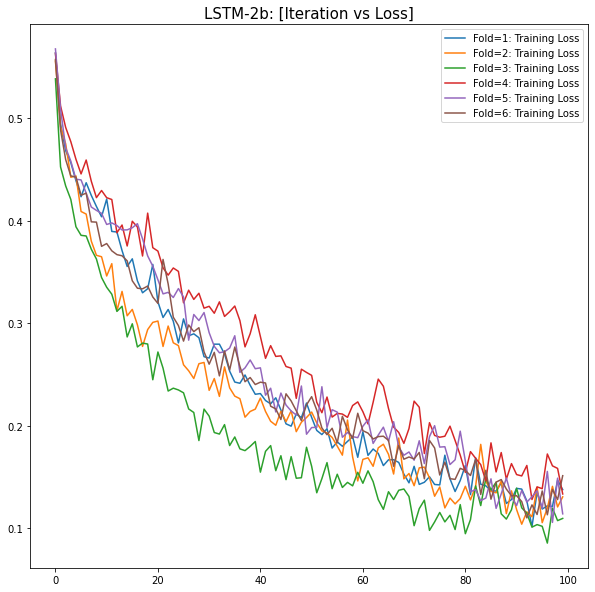

In [9]:
fig = plt.figure(figsize=[10, 10])

plt.plot(hist[0].history['loss'])
plt.plot(hist[1].history['loss'])
plt.plot(hist[2].history['loss'])
plt.plot(hist[3].history['loss'])
plt.plot(hist[4].history['loss'])
plt.plot(hist[5].history['loss'])

plt.title(
    label='LSTM-2b: [Iteration vs Loss]',
    fontdict={
        'fontsize': 15,
        'fontweight': 'medium'
    }
)

plt.legend([
    'Fold=1: Training Loss',
    'Fold=2: Training Loss',
    'Fold=3: Training Loss',
    'Fold=4: Training Loss',
    'Fold=5: Training Loss',
    'Fold=6: Training Loss'
])

plt.savefig(
    fname='K-Fold-Train-Loss.png',
    dpi=400
)

plt.show()

### Training Model:

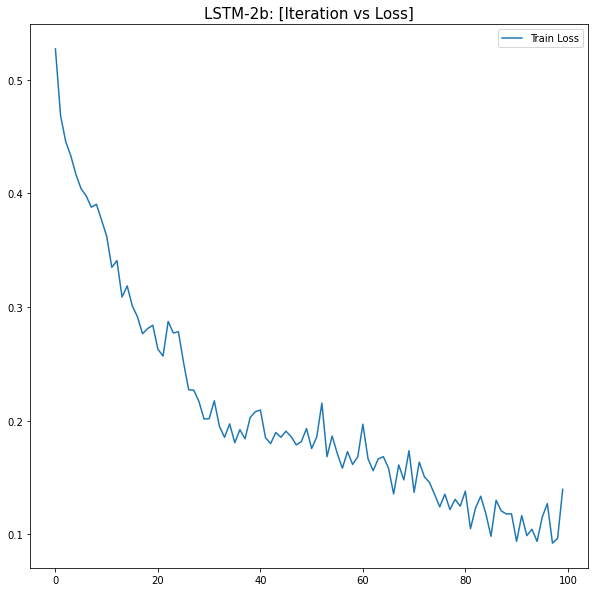

Train Accuracy: 94.83333230018616
Test Accuracy: 84.50000286102295


In [10]:
train_x = []
train_y = []

test_x = []
test_y = []

test_lim_jazz = 0 # jazz
test_lim_classical = 0 # classical
test_lim_blues = 0 # blues
train_lim_jazz = 0
train_lim_classical = 0
train_lim_blues = 0

for entry in processed:
    
    # Test Set:
    if entry['index'] >= 90 and entry['index'] < 100:
        if (entry['ground_truth'] == 'jazz') and test_lim_jazz < 33:
            test_x += [entry['features']]
            test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
            test_lim_jazz += 1
        if (entry['ground_truth'] == 'classical') and test_lim_classical < 34:
            test_x += [entry['features']]
            test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
            test_lim_classical += 1
        if (entry['ground_truth'] == 'blues') and test_lim_blues < 33:
            test_x += [entry['features']]
            test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
            test_lim_blues += 1
        if entry['ground_truth'] in ['disco', 'country']:
            test_x += [entry['features']]
            test_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]

    # Train Set:
    else:
        if entry['ground_truth'] == 'jazz' and train_lim_jazz < 300:
            train_x += [entry['features'].copy()]
            train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
            train_lim_jazz += 1
        if entry['ground_truth'] == 'classical' and train_lim_classical < 300:
            train_x += [entry['features'].copy()]
            train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
            train_lim_classical += 1
        if entry['ground_truth'] == 'blues' and train_lim_blues < 300:
            train_x += [entry['features'].copy()]
            train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
            train_lim_blues += 1
        if entry['ground_truth'] in ['disco', 'country']:
            train_x += [entry['features'].copy()]
            train_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]

train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)


# LSTM-2a Model:
model = create_model({
    'L1': 64,
    'L2': 32
})

hist = model.fit(train_x, train_y, epochs=100, verbose=0)

fig = plt.figure(figsize=[10, 10])

plt.plot(hist.history['loss'])

plt.title(
    label='LSTM-2b: [Iteration vs Loss]',
    fontdict={
        'fontsize': 15,
        'fontweight': 'medium'
    }
)

plt.legend(['Train Loss'])

plt.savefig(
    fname='LSTM-2b-Train-Loss.png',
    dpi=400
)

plt.show()

print('===========================================================')

print('Train Accuracy: {}'.format(100 * model.evaluate(train_x, train_y, verbose=0)[1]))
print('Test Accuracy: {}'.format(100 * model.evaluate(test_x, test_y, verbose=0)[1]))

print('===========================================================')

In [11]:
model.save('./models/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/model/assets
